In [1]:
import io
import re
import zipfile
from collections import OrderedDict

import tensorflow as tf
from PIL import Image
from tqdm import tqdm
import numpy as np
from IPython.display import display

In [2]:
print(tf.__version__)

0.12.0


In [3]:
tf.set_random_seed(0)

In [4]:
def extract_images_bytes(path_64='train_64.zip', path='../CatDog/train.zip'):
    labels_images = OrderedDict()
    # load 64
    z = zipfile.ZipFile(path_64, 'r')
    for file in z.filelist:
        m = re.match('.*(cat|dog).*', file.filename)
        if m:
            category = m.groups()[0]
            if category != 'cat': continue
            img = Image.open(io.BytesIO((z.open(file.filename).read())))
            label = re.sub('[^/]+/', '', file.filename)
            labels_images[label] = [img]
    # load origin
    z = zipfile.ZipFile(path, 'r')
    for file in z.filelist:
        m = re.match('.*(cat|dog).*', file.filename)
        if m:
            category = m.groups()[0]
            if category != 'cat': continue
            label = re.sub('[^/]+/', '', file.filename)
            if label not in labels_images: continue
            img = Image.open(io.BytesIO((z.open(file.filename).read())))
            labels_images[label].append(img)
    return labels_images

In [5]:
train = extract_images_bytes()

In [6]:
X_train = np.array([np.array(x[0]) for x in train.values()])
y_train = np.array([np.array(x[1]) for x in train.values()])

In [7]:
test = extract_images_bytes('test_64.zip', '../CatDog/test.zip')

In [8]:
X_test = np.array([np.array(x[0]) for x in test.values()])
y_test = np.array([np.array(x[1]) for x in test.values()])

In [9]:
mean_of_train = np.mean(X_train)
std_of_train = np.std(X_train)
print(mean_of_train, std_of_train)

114.567369759 66.4041757717


In [10]:
X_train = (X_train - mean_of_train) / std_of_train
X_test = (X_test - mean_of_train) / std_of_train
y_train = (y_train - mean_of_train) / std_of_train
y_test = (y_test - mean_of_train) / std_of_train

In [11]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(10000, 64, 64, 3) (10000, 128, 128, 3) (2500, 64, 64, 3) (2500, 128, 128, 3)


In [12]:
batch_size = 8
learning_rate = 0.1
stddev = 1.0

In [13]:
X = tf.placeholder(tf.float32, [batch_size, 64, 64, 3], name='X')
y = tf.placeholder(tf.float32, [batch_size, 128, 128, 3], name='y')

In [14]:
def conv(input_layer, output_size, pitch_shape, name, strides=[1, 1, 1, 1], padding='VALID'):
    with tf.variable_scope(name):
        shape = [
            pitch_shape[0],
            pitch_shape[1],
            int(input_layer.get_shape()[-1]),
            output_size
        ]
        pitch = tf.Variable(tf.random_normal(shape))
        bias = tf.Variable(tf.zeros([output_size]))
        conv = tf.nn.bias_add(
            tf.nn.conv2d(
                input_layer, pitch, strides=strides, padding=padding
            ),
            bias
        )
        print(name, conv.get_shape())
        return conv

In [15]:
def max_pool(input_layer, name, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID'):
    mp = tf.nn.max_pool(input_layer, ksize=ksize, strides=strides, padding=padding)
    print(name, mp.get_shape())
    return mp

In [16]:
model = X

In [17]:
model = conv(model, 64, (3, 3), 'conv_1', padding='SAME')

conv_1 (8, 64, 64, 64)


In [18]:
model = max_pool(model, 'max_pool_1', padding='SAME')

max_pool_1 (8, 32, 32, 64)


In [19]:
model = conv(model, 128, (3, 3), 'conv_2', padding='SAME')

conv_2 (8, 32, 32, 128)


In [20]:
model = max_pool(model, 'max_pool_2', padding='SAME')

max_pool_2 (8, 16, 16, 128)


In [21]:
pitch_dc = tf.Variable(tf.random_normal([1, 1, 128, 128], stddev=stddev), name='pitch_dc')
pitch_dc_bias = tf.Variable(tf.zeros([128]), name='pitch_dc_bias')

In [22]:
dconv = tf.nn.bias_add(
    tf.nn.conv2d_transpose(
        model, pitch_dc,
        (batch_size, 128, 128, 128),
        (1, 8, 8, 1),
        padding='SAME',
        data_format='NHWC'
    ),
    pitch_dc_bias
)

In [23]:
print(dconv.get_shape())

(8, 128, 128, 128)


In [24]:
pred = conv(dconv, 3, (1, 1), 'pred', padding='SAME')

pred (8, 128, 128, 3)


In [25]:
slice_begin = (int(y.get_shape()[1]) - int(pred.get_shape()[1]))
slice_end = int(pred.get_shape()[1]) + slice_begin

In [26]:
print(slice_begin, slice_end)

0 128


In [27]:
delta = pred - y[:, slice_begin: slice_end, slice_begin: slice_end, :]
delta *= [[[[0.11448, 0.58661, 0.29891]]]]

In [36]:
loss = tf.pow(delta, 2.0)
cost = tf.reduce_mean(tf.reduce_sum(loss, axis=[1, 2, 3]))

In [37]:
opt = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [38]:
params = tf.trainable_variables()

In [39]:
gradients = tf.gradients(cost, params)

In [40]:
clipped_gradients, norm = tf.clip_by_global_norm(gradients, 5.0)

In [41]:
global_step = tf.Variable(0, trainable=False)

In [42]:
train_step = opt.apply_gradients(zip(clipped_gradients, params), global_step=global_step)

In [43]:
init = tf.global_variables_initializer()

In [44]:
def batch_flow(inputs, targets, batch_size):
    """流动数据流"""
    flowed = 0
    total = len(inputs)
    while True:
        X_ret = []
        y_ret = []
        for i in range(total):
            X_ret.append(inputs[i])
            y_ret.append(targets[i])
            if len(X_ret) == batch_size:
                flowed += batch_size
                X, y = np.array(X_ret), np.array(y_ret)
                yield X, y
                X_ret = []
                y_ret = []
            if flowed >= total:
                break
        if flowed >= total:
            break

In [45]:
for batch_x, batch_y in batch_flow(X_train, y_train, batch_size):
    print(batch_x.shape, batch_y.shape)
    break

(8, 64, 64, 3) (8, 128, 128, 3)


In [46]:
n_epoch = 10

In [47]:
with tf.Session() as sess:
    sess.run(init)
    total = None
    for epoch in range(n_epoch):
        costs = []
        for batch_x, batch_y in tqdm(batch_flow(X_train, y_train, batch_size), total=total):
            _, c = sess.run([train_step, cost], feed_dict={X: batch_x, y: batch_y})
            costs.append(c)
        print('epoch: {}, loss: {:.4f}'.format(epoch, np.mean(costs)))
        if total is None:
            total = len(costs)
    print('calculate train accuracy')
    costs = []
    train_result = []
    for batch_x, batch_y in tqdm(batch_flow(X_train, y_train, batch_size)):
        c, p = sess.run([cost, pred], feed_dict={X: batch_x, y: batch_y})
        costs.append(c)
        train_result += list(p)
    print('test loss: {:.4f}'.format(np.mean(costs)))
    print('calculate test accuracy')
    costs = []
    test_result = []
    for batch_x, batch_y in tqdm(batch_flow(X_test, y_test, batch_size)):
        c, p = sess.run([cost, pred], feed_dict={X: batch_x, y: batch_y})
        costs.append(c)
        test_result += list(p)
    print('test loss: {:.4f}'.format(np.mean(costs)))
    print('Done')

1250it [00:28, 43.86it/s]:00,  1.93it/s]
  0%|          | 5/1250 [00:00<00:28, 43.07it/s]

epoch: 0, loss: 7263833088.0000


  0%|          | 5/1250 [00:00<00:29, 41.73it/s]

epoch: 1, loss: 42690704.0000


  0%|          | 4/1250 [00:00<00:31, 39.68it/s]

epoch: 2, loss: 132071224.0000


  0%|          | 5/1250 [00:00<00:28, 43.55it/s]

epoch: 3, loss: 46199840.0000


  0%|          | 5/1250 [00:00<00:28, 42.98it/s]

epoch: 4, loss: 81140536.0000


  0%|          | 4/1250 [00:00<00:31, 39.66it/s]

epoch: 5, loss: 66694952.0000


  0%|          | 5/1250 [00:00<00:30, 41.22it/s]

epoch: 6, loss: 193518800.0000


  0%|          | 5/1250 [00:00<00:30, 40.47it/s]

epoch: 7, loss: 56142960.0000


  0%|          | 5/1250 [00:00<00:30, 40.63it/s]

epoch: 8, loss: 44163008.0000


100%|██████████| 1250/1250 [00:29<00:00, 41.94it/s]1%|          | 15/1250 [00:00<00:29, 41.20it/s]
14it [00:00, 132.56it/s]

epoch: 9, loss: 40971364.0000
calculate train accuracy


1250it [00:08, 143.26it/s]it [00:00, 135.71it/s]
14it [00:00, 138.49it/s]

test loss: 109444008.0000
calculate test accuracy


313it [00:02, 140.32it/s]3it [00:00, 138.37it/s]

test loss: 112712344.0000
Done


In [48]:
def disp(n, mean, std):
    display(
        Image.fromarray(np.uint8(X_train[n] * std + mean)).resize((128, 128), Image.ANTIALIAS),
        Image.fromarray(np.uint8(train_result[n] * std + mean)),
        Image.fromarray(np.uint8(y_train[n] * std + mean))
    )

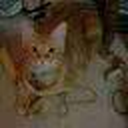

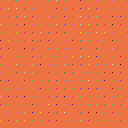

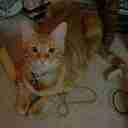

In [49]:
disp(0, mean_of_train, std_of_train)